# Mount Drive



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries and initializing stopwords and stemmer


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

import nltk

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Reading Data


In [3]:
hasoc_data = pd.read_csv("drive/MyDrive/ICHCL_baseline/hasoc2021-train/Hasoc2021_train.csv") #Your respective address
hasoc_data.head()


,Unnamed: 0,_id,text,task_1,task_2
0,4986,60c5d6bf5659ea5e55defa2c,@wealth if you made it through this &amp;&amp;...,HOF,PRFN
1,3394,60c5d6bf5659ea5e55def461,Technically that's still turning back the cloc...,HOF,OFFN
2,1310,60c5d6bf5659ea5e55defaad,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,NOT,NONE
3,3390,60c5d6bf5659ea5e55def419,@krtoprak_yigit Soldier of Japan Who has dick ...,HOF,OFFN
4,4626,60c5d6bf5659ea5e55def7fa,@blueheartedly You'd be better off asking who ...,HOF,OFFN


In [4]:
hasoc_data.describe()

,Unnamed: 0
count,3843.000000
mean,2558.799375
std,1477.088070
min,1.000000
25%,1276.500000
50%,2574.000000
75%,3828.000000
max,5121.000000


In [5]:
tweets = hasoc_data.text
y_task1 = hasoc_data.task_1
y_task2 = hasoc_data.task_2

# Basic Preprocessing of Tweets


In [6]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [9]:
def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)             # removing website links
    text = BeautifulSoup(text, 'lxml').get_text()   # removing html tags
    text = decontract(text)                         # decontracting
    text = re.sub("\S*\d\S*", "", text).strip()     # removing the words with numeric digits
    text = re.sub('[^A-Za-z]+', ' ', text)          # removing non-word characters
    text = text.lower()                             # converting to lower case
    text = [word for word in text.split(" ") if not word in stop_words] # removing stop words
    text = [lemmatizer.lemmatize(token, "v") for token in text] #Lemmatization
    text = " ".join(text)
    text.strip()
    return text

def convert_task(text):
    if text == "HOF":
      return 1
    return 0

In [10]:
hasoc_data["text"] = hasoc_data["text"].apply(lambda x: preprocess_text(x))
hasoc_data["task_1"] = hasoc_data["task_1"].apply(lambda x: convert_task(x))

In [11]:
hasoc_data["text"].head()

0     wealth make not able start make money sustain...
1          technically still turn back clock dick head
2     vmbjp narendramodi jpnadda amitshah dilipghos...
3               krtoprak yigit soldier japan dick head
4     blueheartedly would better ask think sleazy s...
Name: text, dtype: object

In [12]:
hasoc_data["task_1"].head()

0    1
1    1
2    0
3    1
4    1
Name: task_1, dtype: int64

In [13]:
hasoc_data["task_1"].value_counts()

1    2501
0    1342
Name: task_1, dtype: int64

In [14]:
hasoc_data.drop(["Unnamed: 0","_id","task_2"],inplace=True,axis=1)

In [15]:
hasoc_data.head()

,text,task_1
0,wealth make not able start make money sustain...,1
1,technically still turn back clock dick head,1
2,vmbjp narendramodi jpnadda amitshah dilipghos...,0
3,krtoprak yigit soldier japan dick head,1
4,blueheartedly would better ask think sleazy s...,1


In [16]:
train_df, test_df = train_test_split(hasoc_data, test_size = 0.2, random_state = 42)
print("Training data size : ", train_df.shape)
print("Test data size : ", test_df.shape)

Training data size :  (3074, 2)
Test data size :  (769, 2)


#Basic LSTM model and training



In [17]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['text'])

max_review_length = 130
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['task_1']

In [18]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 32)           192032    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 245,333
Trainable params: 245,333
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train,y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
39/39 [==============================] - 22s 34ms/step - loss: 0.6624 - accuracy: 0.6536 - val_loss: 0.6382 - val_accuracy: 0.6439
Epoch 2/100
39/39 [==============================] - 1s 13ms/step - loss: 0.5924 - accuracy: 0.6928 - val_loss: 0.5562 - val_accuracy: 0.6911
Epoch 3/100
39/39 [==============================] - 0s 13ms/step - loss: 0.4088 - accuracy: 0.8362 - val_loss: 0.5170 - val_accuracy: 0.7545
Epoch 4/100
39/39 [==============================] - 0s 12ms/step - loss: 0.2668 - accuracy: 0.9101 - val_loss: 0.5622 - val_accuracy: 0.7398
Epoch 5/100
39/39 [==============================] - 1s 15ms/step - loss: 0.1486 - accuracy: 0.9555 - val_loss: 0.6652 - val_accuracy: 0.7350
Epoch 6/100
39/39 [==============================] - 1s 13ms/step - loss: 0.0929 - accuracy: 0.9730 - val_loss: 0.7269 - val_accuracy: 0.7203
Epoch 7/100
39/39 [==============================] - 0s 13ms/step - loss: 0.0721 - accuracy: 0.9811 - val_loss: 0.9768 - val_accuracy: 0.7220
Epoch

Result Evaluation model for Basic LSTM Model

In [20]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['task_1']
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.717815344603381
F1-score:  0.7923444976076555
Confusion matrix:


array([[138, 102],
       [115, 414]])

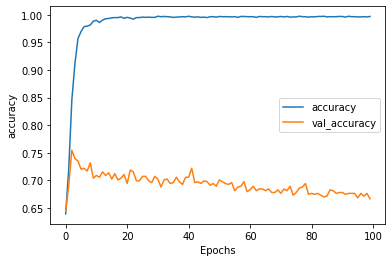

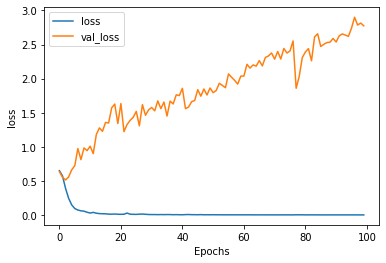

In [40]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

#Bidirectional GRU model and training

In [41]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 130, 32)           192032    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                12672     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 205,101
Trainable params: 205,101
Non-trainable params: 0
_________________________________________________________________


In [42]:
history2 = model2.fit(X_train,y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
39/39 [==============================] - 4s 42ms/step - loss: 0.6582 - accuracy: 0.6409 - val_loss: 0.6407 - val_accuracy: 0.6439
Epoch 2/100
39/39 [==============================] - 1s 16ms/step - loss: 0.5959 - accuracy: 0.6523 - val_loss: 0.5574 - val_accuracy: 0.7301
Epoch 3/100
39/39 [==============================] - 1s 17ms/step - loss: 0.4300 - accuracy: 0.8259 - val_loss: 0.5261 - val_accuracy: 0.7463
Epoch 4/100
39/39 [==============================] - 1s 16ms/step - loss: 0.2593 - accuracy: 0.8987 - val_loss: 0.6013 - val_accuracy: 0.7561
Epoch 5/100
39/39 [==============================] - 1s 16ms/step - loss: 0.1434 - accuracy: 0.9492 - val_loss: 0.6941 - val_accuracy: 0.7545
Epoch 6/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0851 - accuracy: 0.9768 - val_loss: 0.8025 - val_accuracy: 0.7138
Epoch 7/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0648 - accuracy: 0.9817 - val_loss: 0.8790 - val_accuracy: 0.7203
Epoch 

Result and plot of Bidirectional GRU

In [43]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['task_1']
prediction = model2.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.7269180754226268
F1-score:  0.8022598870056498
Confusion matrix:


array([[133, 107],
       [103, 426]])

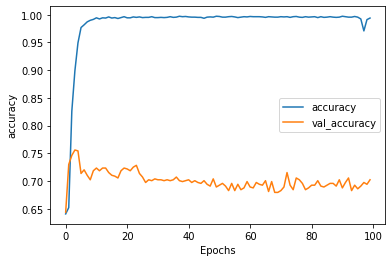

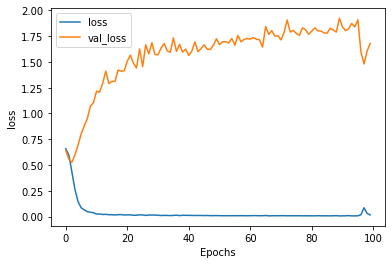

In [44]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')

#Bidirectional LSTM 

In [45]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [46]:
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 130, 32)           192032    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 130, 128)          49664     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 287,137
Trainable params: 287,137
Non-trainable params: 0
_________________________________________________________________


In [47]:
history3 = model3.fit(X_train,y_train, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
39/39 [==============================] - 7s 59ms/step - loss: 0.6439 - accuracy: 0.6389 - val_loss: 0.6223 - val_accuracy: 0.6439
Epoch 2/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4705 - accuracy: 0.7869 - val_loss: 0.5400 - val_accuracy: 0.7545
Epoch 3/100
39/39 [==============================] - 1s 27ms/step - loss: 0.2419 - accuracy: 0.9138 - val_loss: 0.6339 - val_accuracy: 0.7431
Epoch 4/100
39/39 [==============================] - 1s 27ms/step - loss: 0.1385 - accuracy: 0.9536 - val_loss: 0.6686 - val_accuracy: 0.7642
Epoch 5/100
39/39 [==============================] - 1s 26ms/step - loss: 0.0876 - accuracy: 0.9723 - val_loss: 0.8627 - val_accuracy: 0.7350
Epoch 6/100
39/39 [==============================] - 1s 27ms/step - loss: 0.0579 - accuracy: 0.9821 - val_loss: 1.1092 - val_accuracy: 0.7350
Epoch 7/100
39/39 [==============================] - 1s 27ms/step - loss: 0.0494 - accuracy: 0.9854 - val_loss: 1.0372 - val_accuracy: 0.7382
Epoch 

Result and plot of Bidirectional LSTM

In [48]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['task_1']
prediction = model3.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.729518855656697
F1-score:  0.8022813688212929
Confusion matrix:


array([[139, 101],
       [107, 422]])

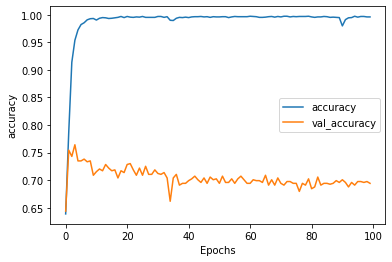

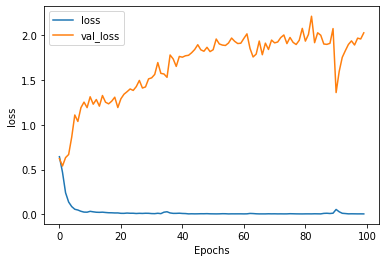

In [49]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')

#Conv1D

In [57]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [51]:
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 130, 32)           192032    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 126, 128)          20608     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 774       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 7         
Total params: 213,421
Trainable params: 213,421
Non-trainable params: 0
_________________________________________________________________


In [52]:
history4 = model4.fit(X_train,y_train, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
39/39 [==============================] - 1s 12ms/step - loss: 0.6559 - accuracy: 0.6409 - val_loss: 0.6506 - val_accuracy: 0.6439
Epoch 2/100
39/39 [==============================] - 0s 8ms/step - loss: 0.6484 - accuracy: 0.6409 - val_loss: 0.6461 - val_accuracy: 0.6439
Epoch 3/100
39/39 [==============================] - 0s 7ms/step - loss: 0.6234 - accuracy: 0.6409 - val_loss: 0.6276 - val_accuracy: 0.6439
Epoch 4/100
39/39 [==============================] - 0s 8ms/step - loss: 0.5696 - accuracy: 0.6564 - val_loss: 0.6155 - val_accuracy: 0.6683
Epoch 5/100
39/39 [==============================] - 0s 9ms/step - loss: 0.5189 - accuracy: 0.7926 - val_loss: 0.6103 - val_accuracy: 0.6862
Epoch 6/100
39/39 [==============================] - 0s 8ms/step - loss: 0.4728 - accuracy: 0.8329 - val_loss: 0.6218 - val_accuracy: 0.6894
Epoch 7/100
39/39 [==============================] - 0s 8ms/step - loss: 0.4271 - accuracy: 0.8711 - val_loss: 0.6200 - val_accuracy: 0.6862
Epoch 8/100


Result and Plot of Conv1D

In [53]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['task_1']
prediction = model4.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.7321196358907672
F1-score:  0.8063909774436091
Confusion matrix:


array([[134, 106],
       [100, 429]])

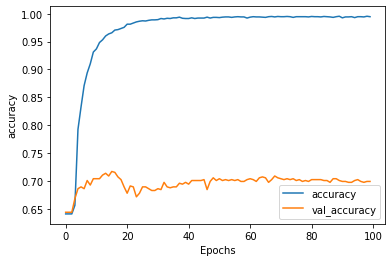

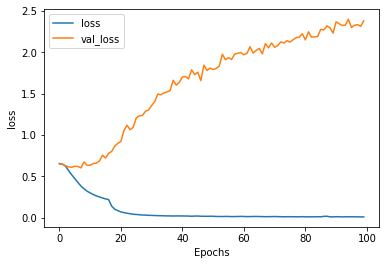

In [54]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history4, 'accuracy')
plot_graphs(history4, 'loss')